In [1]:
import os
import shutil
import pickle
import random

from tqdm import tqdm

import recipe_utils
import recipe_analysis
from recipe import XMLRecipe

In [16]:
repo_root = '.'
recipes_path = os.path.join(repo_root, 'data', 'list_recipes.pkl')
ingredients_path = os.path.join(repo_root, 'data', 'zutaten.pkl')
utensils_path = os.path.join(repo_root, 'data', 'materielle.pkl')
output_path = os.path.join(repo_root, 'output', 'workshop')

with open(recipes_path, "rb") as f:
    recipes =  pickle.load(f)

with open(ingredients_path, "rb") as f:
    ingredients =  pickle.load(f)
    
with open(utensils_path, "rb") as f:
    utensils =  pickle.load(f)

In [ ]:
title_2_doc = {}
for recipe in tqdm(recipes):
    title_2_doc[recipe_utils.get_recipe_title(recipe)] = recipe

100%|██████████| 6892/6892 [01:27<00:00, 78.56it/s] 


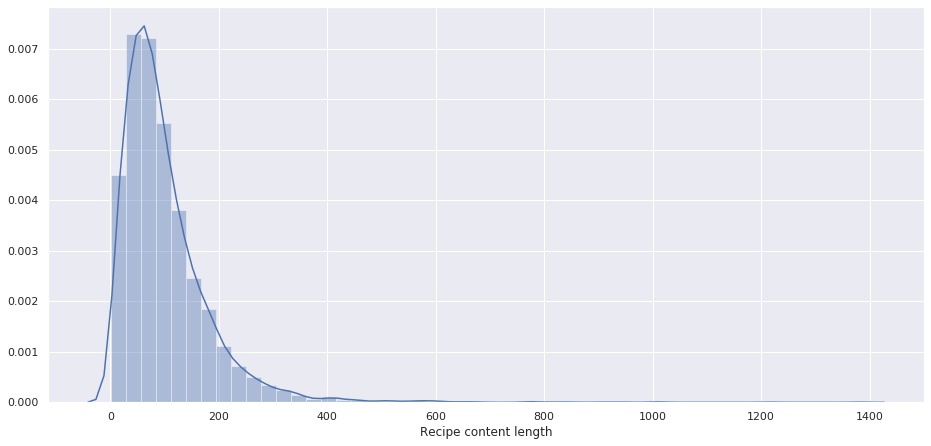

In [3]:
length_per_recipe = recipe_analysis.get_lengths_and_lang(recipes)
recipe_analysis.create_length_per_recipe_chart(length_per_recipe)

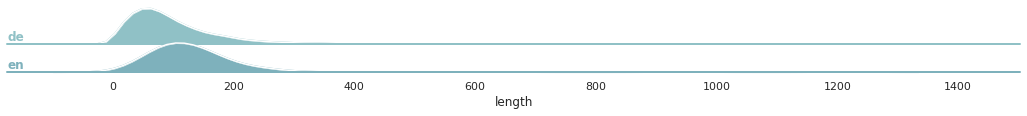

In [4]:
recipe_analysis.create_facet_grid(length_per_recipe)

In [5]:
length_per_recipe.groupby('lang').describe()

recipe                                                 length             \
      count unique                                 top freq  count unique top   
lang                                                                            
af        1      1                       Honig läutern    1      1      1  27   
ca        1      1                          Item Salsa    1      1      1  41   
de     6647   6598                            Anderst.    5   6647    416  50   
en      233    232               To make Almond-Butter    2    233    138  99   
fr        2      2   Item salsa que servatur per annum    1      2      2  77   
it        2      2                     Item salsa alba    1      2      2  31   
nl        6      6  [Pirckhan kalt in einer Pasteten.]    1      6      3   5   

           
     freq  
lang       
af      1  
ca      1  
de     66  
en      6  
fr      1  
it      1  
nl      4

In [6]:
def get_quantiles(length_per_recipe, lang='de'):
    recipes = length_per_recipe[length_per_recipe.lang == lang]
    quantiles_20 = recipes.length.quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
    return quantiles_20

In [7]:
def get_random_recipes(length_per_recipe, lb, ub, lang='de', n=9):
    recipes = length_per_recipe[length_per_recipe.lang == lang]
    match_lower_bound = recipes.length > lb
    match_upper_bound = recipes.length < ub
    match = recipes[match_lower_bound & match_upper_bound]
        
    titles = []
    for _ in range(n):
        idx = random.randint(0, len(match)-1)
        titles.append(match.iloc[idx, 0])
    
    return titles

In [8]:
def reset_workshop(n_groups):
    for directory in os.listdir(output_path):
        shutil.rmtree(os.path.join(output_path, directory), ignore_errors=True)
        
    create_folders(n_groups)
    
def create_folders(n_groups):
    os.mkdir(os.path.join(output_path, 'annotated'))
    os.mkdir(os.path.join(output_path, 'original'))
    
    for group in range(n_groups):
        os.mkdir(os.path.join(output_path, 'annotated', f'group_{group}'))
        os.mkdir(os.path.join(output_path, 'original', f'group_{group}'))      

In [29]:
def create_docs(length_per_recipe, title_2_doc, n_short_docs, n_average_docs, lang, n_long_docs):
    quantiles_20 = get_quantiles(length_per_recipe, lang)
    
    for group in tqdm(range(n_groups)):
        annotated_path = os.path.join(output_path, 'annotated', f'group_{group}')
        original_path = os.path.join(output_path, 'original', f'group_{group}')

        recipes = get_random_recipes(length_per_recipe, 
                                     quantiles_20[0.4], 
                                     quantiles_20[0.6], 
                                     lang, 
                                     n_short_docs)
        for i, recipe_title in enumerate(recipes):
            r = recipe.XMLRecipe(title_2_doc[recipe_title], ingredients, utensils)
            with open(os.path.join(annotated_path, f'group_{group}_short_annotated_{i}.xml'), 'w') as f:
                f.write(r.annotated)
            with open(os.path.join(original_path, f'group_{group}_short_original_{i}.xml'), 'w') as f:
                f.write(r.original)

        recipes = get_random_recipes(length_per_recipe, 
                                     quantiles_20[0.6], 
                                     quantiles_20[0.8], 
                                     lang, 
                                     n_long_docs)
        for i, recipe_title in enumerate(recipes):
            r = recipe.XMLRecipe(title_2_doc[recipe_title], ingredients, utensils)
            with open(os.path.join(annotated_path, f'group_{group}_average_annotated_{i}.xml'), 'w') as f:
                f.write(r.annotated)
            with open(os.path.join(original_path, f'group_{group}_average_original_{i}.xml'), 'w') as f:
                f.write(r.original)
                
        recipes = get_random_recipes(length_per_recipe, 
                                     quantiles_20[0.8], 
                                     quantiles_20[1], 
                                     lang, 
                                     n_long_docs)
        for i, recipe_title in enumerate(recipes):
            r = recipe.XMLRecipe(title_2_doc[recipe_title], ingredients, utensils)
            with open(os.path.join(annotated_path, f'group_{group}_long_annotated_{i}.xml'), 'w') as f:
                f.write(r.annotated)
            with open(os.path.join(original_path, f'group_{group}_long_original_{i}.xml'), 'w') as f:
                f.write(r.original)

In [59]:
n_groups = 10
n_short_docs = 4
n_average_docs = 4
n_long_docs = 4
lang = 'en'

reset_workshop(n_groups)
create_docs(length_per_recipe, title_2_doc, n_short_docs, n_average_docs, lang, n_long_docs)

100%|██████████| 10/10 [00:36<00:00,  3.66s/it]
